In [1]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


In [46]:
import george
from george.kernels import ExpSquaredKernel, MyLocalGaussianKernel, ExpKernel, MyLocalExpSquared
from scipy.optimize import curve_fit
import triangle
from lmfit import Parameters, minimize, fit_report
import emcee
pl = plt

## Load data

In [34]:
#np.savetxt('dijet_data.csv', (xval, xerrminus, xerrplus, yval, yerr, xerr))

In [35]:
xval, xerrminus, xerrplus, yval, yerr, xerr = np.loadtxt('dijet_data.csv')
#scale data by bin width since curve-fit can't have the model take in an argument
newy = yval/(xerrplus+xerrminus) 

## Define standard CDF dijet fitting function

Notice that curve_fit is a least squares fit and minimize will minimize what is given, but residual_CDF2009 isn't a -logL

In [36]:
def model2_CDF2009(t, params): 
    p0, p1, p2, p3 = params
    sqrts = 8000.
    return (p0 * (1.-t/sqrts)**p1 * (t/sqrts)**(p2+p3*np.log(t/sqrts)))

In [37]:
def nll(params, t,data=None): #gaussian distribution
    #p0, p1, p2, p3 = params
    #vals = params.valuesdict()
    #p0 =  vals['p0']
    #p1 =  vals['p1']
    #p2 = vals['p2']
    #p3 = vals['p3']
    #sqrts = 8000.
    #prediction = p0 * (1.-t/sqrts)**p1 * (t/sqrts)**(p2+p3*np.log(t/sqrts))
    prediction = model2_CDF2009(t,params.valuesdict().values() )
    return (prediction-data)/np.sqrt(prediction)

In [38]:
#initialize parameters
fit_params = Parameters()
fit_params.add('p0', value=0.0490546530927)
fit_params.add('p1', value=7.3087377889)
fit_params.add('p2', value=-6.00446454843)
fit_params.add('p3', value=0.1347386042)

In [39]:
model2_CDF2009(xval, fit_params.valuesdict().values())

array([  1.50791949e+08,   8.79284247e+07,   5.13914184e+07,
         3.08370337e+07,   1.85587839e+07,   1.12199432e+07,
         6.88295446e+06,   4.28094106e+06,   2.69737581e+06,
         1.72051891e+06,   1.11017267e+06,   7.28979331e+05,
         4.83280078e+05,   3.21404397e+05,   2.15726418e+05,
         1.45279276e+05,   9.81919888e+04,   6.69449223e+04,
         4.60147337e+04,   3.17302611e+04,   2.19531008e+04,
         1.52402128e+04,   1.05749904e+04,   7.33779220e+03,
         5.11170533e+03,   3.57460986e+03,   2.50896702e+03,
         1.76164205e+03,   1.23759485e+03,   8.70035806e+02,
         6.12116022e+02,   4.31013847e+02,   3.02941291e+02,
         2.13138552e+02,   1.49723574e+02,   1.05028128e+02,
         7.37515866e+01,   5.17163812e+01,   3.62146211e+01,
         2.53238358e+01,   1.76450303e+01,   1.22767354e+01,
         8.52806781e+00,   5.90196661e+00,   4.06898832e+00,
         2.79951930e+00,   1.91804436e+00,   1.30356058e+00,
         8.80309835e-01,

('do fit', '[[Variables]]\n    p0:   0.04905465 (init= 0.04905465)\n    p1:   7.30873778 (init= 7.308738)\n    p2:  -6.00446454 (init=-6.004465)\n    p3:   0.13473860 (init= 0.1347386)\n[[Correlations]] (unreported correlations are <  0.100)')


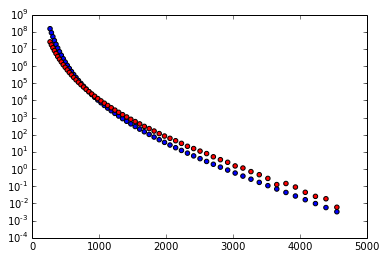

In [40]:
#do fit
out = minimize(nll, fit_params, args=(xval,), kws={'data':newy})

print("do fit", fit_report(fit_params))

plt.scatter(xval, model2_CDF2009(xval,  fit_params.valuesdict().values()))
plt.scatter(xval, newy, c='r')
plt.ylim([10e-5, 10e8])
plt.yscale('log')

(-100.0, 100.0)

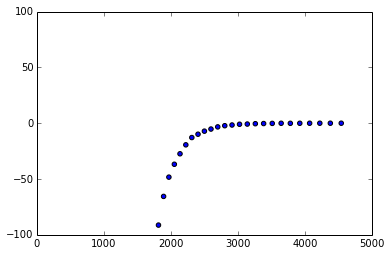

In [41]:
plt.scatter(xval, model2_CDF2009(xval,fit_params.valuesdict().values() )-newy) 
plt.ylim(-1E2,1E2)

## Do MCMC on the CDF fit function

In [42]:
def model_ind(params, t): 
    global xerr
    p0, p1, p2, p3 = params
    sqrts = 8000.
    return (p0 * (1.-t/sqrts)**p1 * (t/sqrts)**(p2+p3*np.log(t/sqrts)))*xerr

def lnlike_ind(p, t, y, yerr):
    return -0.5 * np.sum(((y - model_ind(p, t))/np.sqrt(model_ind(p,t))) ** 2) 
    # return p1*math.log(1-t)+(p2+p3*math.log(t)

def lnprior_ind(p):
    p0, p1, p2, p3 = p
    if (0 < p0 < 5 and  0 < p1 < 10 and -10 < p2 < 0 and
            -1 < p3 < 1):
        return 0.0
    return -np.inf


def lnprob_ind(p, x, y, yerr): 
    lp = lnprior_ind(p) 
    return lp + lnlike_ind(p, x, y, yerr) if np.isfinite(lp) else -np.inf

In [43]:
def fit_ind(initial, data, nwalkers=32):
    ndim = len(initial)
    p0 = [np.array(initial) + 1e-8 * np.random.randn(ndim)
          for i in xrange(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_ind, args=data)
    print("Running burn-in")
    p0, lnp, _ = sampler.run_mcmc(p0, 500)
    sampler.reset()

    print("Running second burn-in")
    p = p0[np.argmax(lnp)]
    p0 = [p + 1e-8 * np.random.randn(ndim) for i in xrange(nwalkers)]
    p0, _, _ = sampler.run_mcmc(p0, 500)
    sampler.reset()

    print("Running production")
    p0, _, _ = sampler.run_mcmc(p0, 1000)
    return sampler

In [44]:
def doit():
    np.random.seed(1234)
    truth = [fitps[0], fitps[1], fitps[2], fitps[3]]
    data = (xval, yval, np.sqrt(yval))
    # Fit assuming GP.
    print("Fitting ind")
    sampler = fit_ind(truth, data)
    # Plot the samples in data space.
    print("Making plots")
    samples = sampler.flatchain

    residuals = model_ind(truth, xval)-yval
    pl.figure()
    pl.errorbar(xval, abs(residuals), yerr=np.sqrt(yval), fmt=".k", capsize=0)
    modelMatrix=np.empty([samples.shape[0], len(xval)])
    i=0
    print(len(samples), len(xval), samples.shape)
    for s in samples:
        #randint(32000, 24) returns array of length 24 filled with random ints from 0 to 32000
        #samples(randint) retuns an array of length 24 filled with position of the parameter in sample definited by the random int
        modelMatrix[i,:]=model_ind(s,xval)-yval
        pl.scatter(xval, abs(model_ind(s, xval)-yval), color="#4682b4", alpha=0.3)
        i+=1
       # print(model_ind(s, xval)-yval)
    pl.ylabel(r"$xs$")
    pl.xlabel(r"$m_{jj}$")
    pl.yscale('log')
    print(modelMatrix.shape)

In [ ]:
doit()

Fitting ind
Running burn-in
Running second burn-in
Running production
Making plots